In [2]:
!pip install scikit-fuzzy pandas matplotlib numpy streamlit seaborn ta
!pip install vnstock==0.2.5

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 30.7 MB/s eta 0:00:00
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=44128e63cb5b9ed6c7f9aa528107fe43051db32d5c68a2776221ad9dd17f8499
  Stored in directory: /root/.cache/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta


In [3]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import ta
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, accuracy_score,
                             classification_report, ConfusionMatrixDisplay,
                             balanced_accuracy_score)
from vnstock import *
from datetime import datetime

data = stock_historical_data(symbol='VIC', start_date='2015-01-01', end_date ='2025-11-11' )
data.to_csv("VIC.csv",index =False)
import pandas as pd
df = pd.read_csv("VIC.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2711 entries, 0 to 2710
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   time    2711 non-null   object
 1   open    2711 non-null   int64 
 2   high    2711 non-null   int64 
 3   low     2711 non-null   int64 
 4   close   2711 non-null   int64 
 5   volume  2711 non-null   int64 
 6   ticker  2711 non-null   object
dtypes: int64(5), object(2)
memory usage: 148.4+ KB


In [9]:
df.head(10)
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d')

**BIỂU ĐỒ GIÁ CỔ PHIẾU VIC THEO THỜI GIAN**


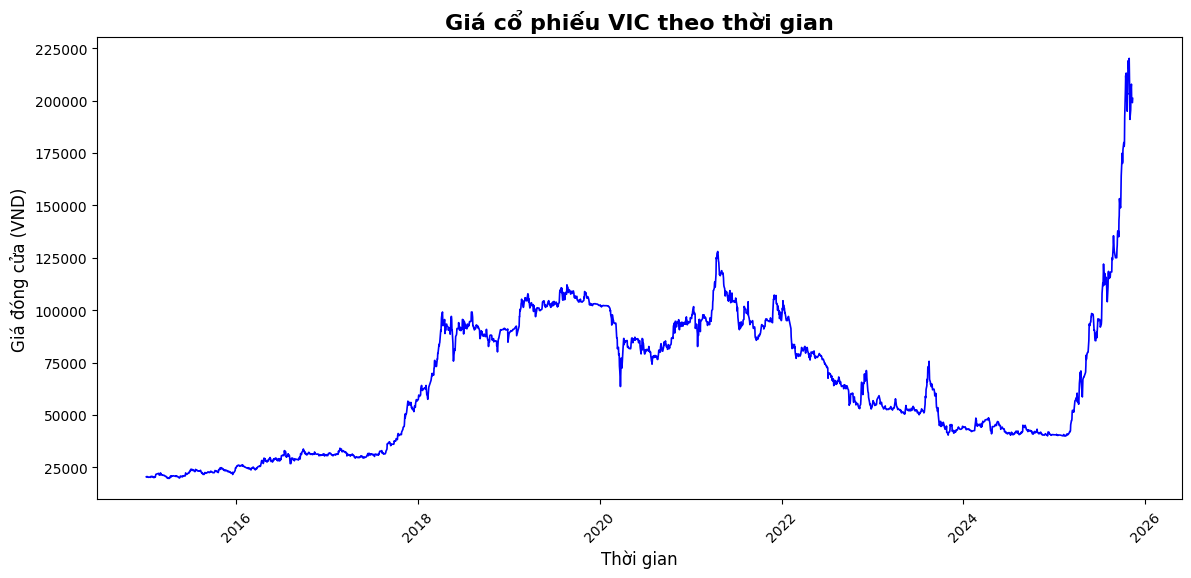

In [5]:
print("**BIỂU ĐỒ GIÁ CỔ PHIẾU VIC THEO THỜI GIAN**")
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(df['time'], df['close'], color='blue', linewidth=1.2)
ax.set_title("Giá cổ phiếu VIC theo thời gian", fontsize=16, fontweight='bold')
ax.set_xlabel("Thời gian", fontsize=12)
ax.set_ylabel("Giá đóng cửa (VND)", fontsize=12)
ax.tick_params(axis='x', rotation=45)
plt.show(fig)

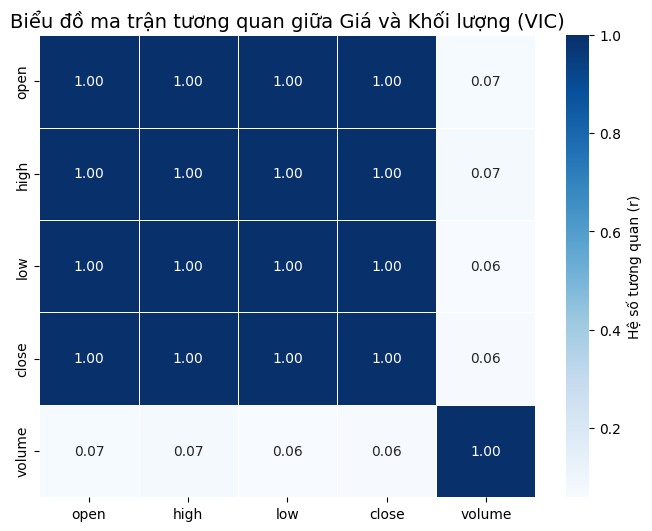

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
numeric_cols = ['open', 'high', 'low', 'close', 'volume']
# Đảm bảo các cột giá là kiểu số
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Tính toán ma trận tương quan
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix,
            annot=True,
            fmt=".2f",
            cmap="Blues",
            linewidths=.5,
            cbar_kws={'label': 'Hệ số tương quan (r)'})
plt.title("Biểu đồ ma trận tương quan giữa Giá và Khối lượng (VIC)", fontsize=14)
plt.show()

In [7]:
# 1. CÀI ĐẶT THAM SỐ
TARGET_THRESHOLD = 0.005  # Ngưỡng 0.5%
TRAIN_PERIOD = 504        # ~2 years
TEST_PERIOD = 63          # ~1 quarter
STEP = 21                 # ~1 month
RF_PARAMS = {
    'n_estimators': 300,
    'max_depth': 10,
    'min_samples_split': 10,
    'n_jobs': -1,
    'class_weight': 'balanced',
    'random_state': 42
}

print("="*70)
print("ĐÁNH GIÁ MÔ HÌNH DỰ ĐOÁN GIÁ CỔ PHIẾU VIC")
print("Model 1: Fuzzy Logic (4 chỉ số) | Model 2: Hybrid Fuzzy + RF)")
print(f"Ngưỡng: ±{TARGET_THRESHOLD*100:.1f}% | Walk-Forward: {TRAIN_PERIOD}/{TEST_PERIOD}/{STEP}")
print("="*70)

# 2. TẢI DỮ LIỆU & TÍNH CHỈ BÁO
# -----------------------------
print("\n1) Tải dữ liệu và tính chỉ báo...")
df = stock_historical_data('VIC', '2015-01-01', '2025-11-11')[['time','open','high','low','close','volume']]
df['time'] = pd.to_datetime(df['time'])
df.sort_values('time', inplace=True); df.reset_index(drop=True, inplace=True)

df['RSI'] = ta.momentum.RSIIndicator(df['close'], 14).rsi()
df['MACD_Hist'] = ta.trend.MACD(df['close']).macd_diff()
df['ADX'] = ta.trend.ADXIndicator(df['high'], df['low'], df['close'], 14).adx()
df['STO'] = ta.momentum.StochasticOscillator(df['high'], df['low'], df['close'], 14).stoch()
df['BB_P'] = ta.volatility.BollingerBands(df['close'], 20).bollinger_pband()
df['Volume_Ratio'] = df['volume'] / df['volume'].rolling(20).mean()

# Target
future_return = df['close'].shift(-1) / df['close'] - 1
df['Target'] = np.select([future_return > TARGET_THRESHOLD, future_return < -TARGET_THRESHOLD], [2, 0], default=1)
df.dropna(inplace=True); df.reset_index(drop=True, inplace=True)

print(f"   → Số mẫu: {len(df)}")
print(f"   → Phân bố lớp: \n{pd.Series(df['Target']).value_counts(normalize=True).sort_index()}")


ĐÁNH GIÁ MÔ HÌNH DỰ ĐOÁN GIÁ CỔ PHIẾU VIC
Model 1: Fuzzy Logic (4 chỉ số) | Model 2: Hybrid Fuzzy + RF)
Ngưỡng: ±0.5% | Walk-Forward: 504/63/21

1) Tải dữ liệu và tính chỉ báo...
   → Số mẫu: 2678
   → Phân bố lớp: 
Target
0    0.292382
1    0.414862
2    0.292756
Name: proportion, dtype: float64


Trực quan hóa 6 chỉ báo kỹ thuật chính (500 ngày gần nhất)...


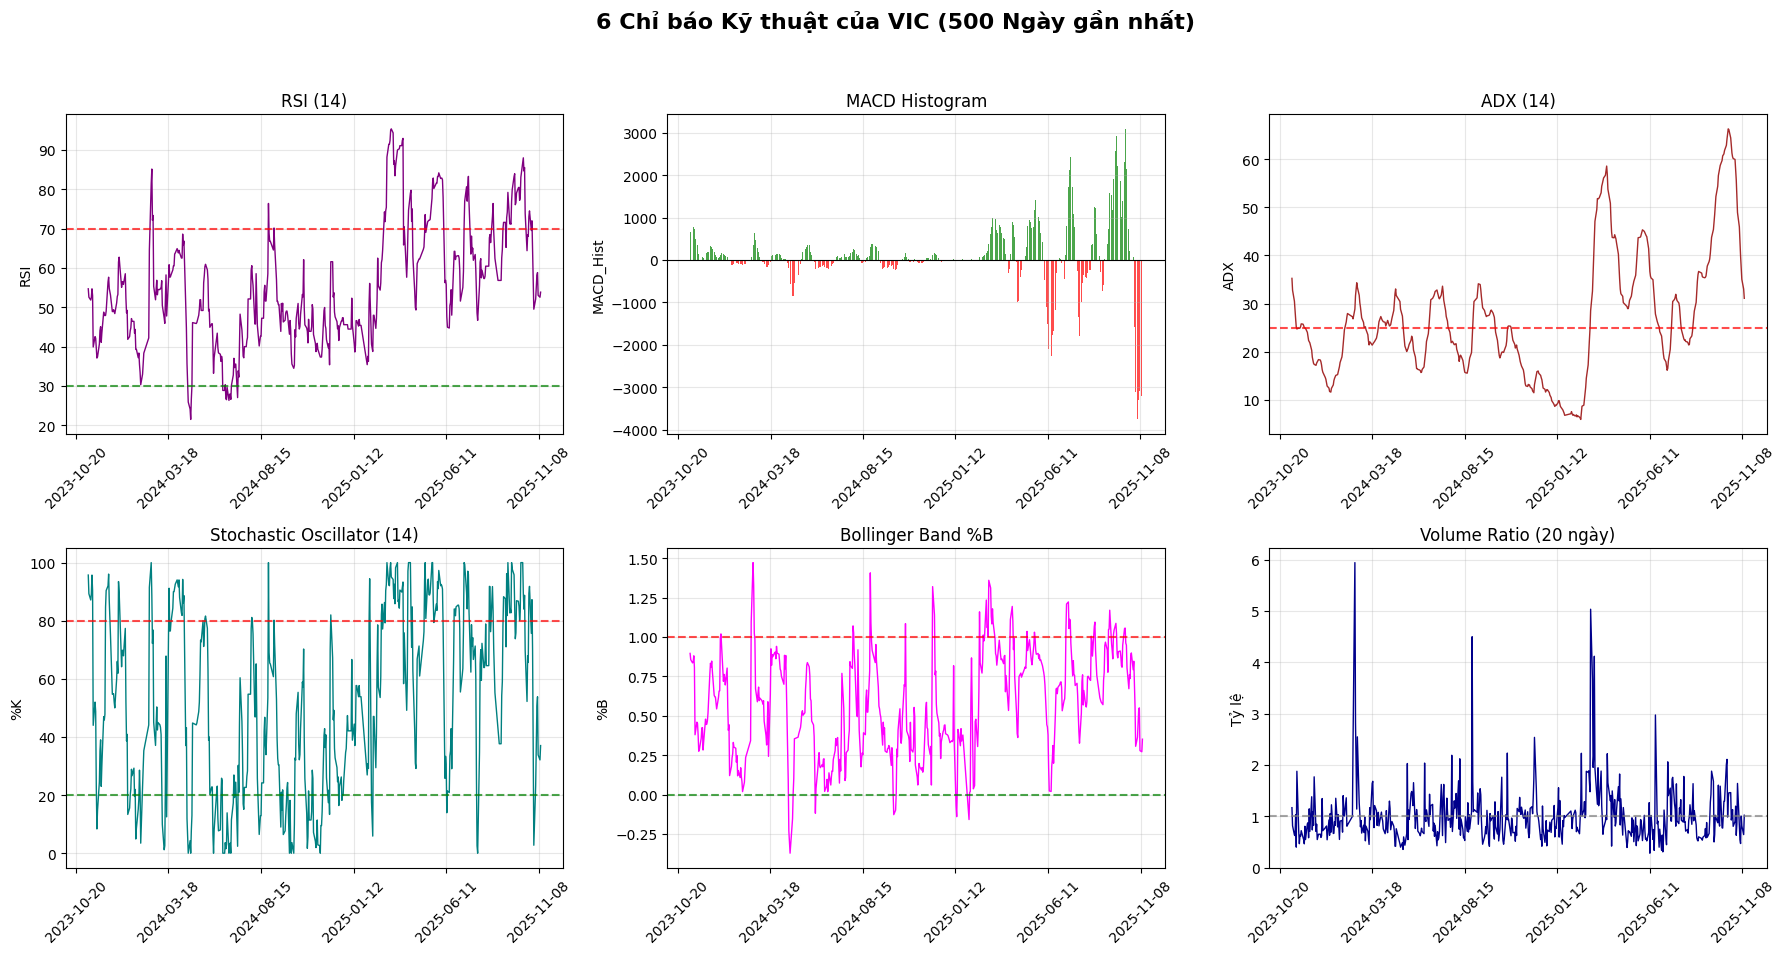

In [10]:
# ================================================================
# BIỂU ĐỒ 6 CHỈ BÁO KỸ THUẬT (EDA)
# ================================================================
print("Trực quan hóa 6 chỉ báo kỹ thuật chính (500 ngày gần nhất)...")

# Chỉ lấy 500 điểm gần nhất để biểu đồ rõ ràng hơn
plot_data = df.tail(500)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle(f"6 Chỉ báo Kỹ thuật của VIC (500 Ngày gần nhất)", fontsize=16, fontweight='bold')

# --- 1. RSI ---
axes[0, 0].plot(plot_data['time'], plot_data['RSI'], color='purple', linewidth=1)
axes[0, 0].axhline(70, color='red', linestyle='--', alpha=0.7)
axes[0, 0].axhline(30, color='green', linestyle='--', alpha=0.7)
axes[0, 0].set_title("RSI (14)");
axes[0, 0].set_ylabel("RSI");
axes[0, 0].grid(alpha=0.3)

# --- 2. MACD Histogram ---
macd_colors = np.where(plot_data['MACD_Hist'] > 0, 'g', 'r')
axes[0, 1].bar(plot_data['time'], plot_data['MACD_Hist'], color=macd_colors, alpha=0.7, width=1)
axes[0, 1].axhline(0, color='black', linewidth=0.8)
axes[0, 1].set_title("MACD Histogram");
axes[0, 1].set_ylabel("MACD_Hist");
axes[0, 1].grid(alpha=0.3)

# --- 3. ADX ---
axes[0, 2].plot(plot_data['time'], plot_data['ADX'], color='brown', linewidth=1)
axes[0, 2].axhline(25, color='red', linestyle='--', alpha=0.7)
axes[0, 2].set_title("ADX (14)");
axes[0, 2].set_ylabel("ADX");
axes[0, 2].grid(alpha=0.3)

# --- 4. Stochastic ---
axes[1, 0].plot(plot_data['time'], plot_data['STO'], color='teal', linewidth=1)
axes[1, 0].axhline(80, color='red', linestyle='--', alpha=0.7)
axes[1, 0].axhline(20, color='green', linestyle='--', alpha=0.7)
axes[1, 0].set_title("Stochastic Oscillator (14)");
axes[1, 0].set_ylabel("%K");
axes[1, 0].grid(alpha=0.3)

# --- 5. Bollinger Band %B ---
axes[1, 1].plot(plot_data['time'], plot_data['BB_P'], color='magenta', linewidth=1)
axes[1, 1].axhline(1.0, color='red', linestyle='--', alpha=0.7)
axes[1, 1].axhline(0.0, color='green', linestyle='--', alpha=0.7)
axes[1, 1].set_title("Bollinger Band %B");
axes[1, 1].set_ylabel("%B");
axes[1, 1].grid(alpha=0.3)

# --- 6. Volume Ratio ---
axes[1, 2].plot(plot_data['time'], plot_data['Volume_Ratio'], color='darkblue', linewidth=1)
axes[1, 2].axhline(1.0, color='gray', linestyle='--', alpha=0.7)
axes[1, 2].set_title("Volume Ratio (20 ngày)");
axes[1, 2].set_ylabel("Tỷ lệ");
axes[1, 2].grid(alpha=0.3)

# Xoay nhãn + căn chỉnh
for ax in axes.flat:
    ax.tick_params(axis='x', rotation=45)
    ax.xaxis.set_major_locator(plt.MaxNLocator(6)) # Giảm nhãn trục X

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [22]:
# -----------------------------
# 3. HỆ FUZZY (4 INPUT)
# -----------------------------
print("\n2) Xây dựng hệ Fuzzy...")
def make_mf(var, name):
    var[f'{name}_Low'] = fuzz.trapmf(var.universe, [0.0, 0.0, 0.30, 0.40])
    var[f'{name}_Mid'] = fuzz.trimf(var.universe, [0.30, 0.50, 0.70])
    var[f'{name}_High'] = fuzz.trapmf(var.universe, [0.60, 0.70, 1.0, 1.0])

rsi = ctrl.Antecedent(np.arange(0,1.01,0.01), 'RSI')
macd_hist = ctrl.Antecedent(np.arange(0,1.01,0.01), 'MACD_Hist')
adx = ctrl.Antecedent(np.arange(0,1.01,0.01), 'ADX')
sto = ctrl.Antecedent(np.arange(0,1.01,0.01), 'STO')
signal = ctrl.Consequent(np.arange(0,1.01,0.01), 'Signal')

for v, n in zip([rsi, macd_hist, adx, sto], ['RSI','MACD_Hist','ADX','STO']):
    make_mf(v, n)

signal['Down'] = fuzz.trapmf(signal.universe, [0.0, 0.0, 0.30, 0.45])
signal['Neutral'] = fuzz.trimf(signal.universe, [0.40, 0.50, 0.60])
signal['Up'] = fuzz.trapmf(signal.universe, [0.55, 0.70, 1.0, 1.0])

rules = [
    ctrl.Rule(rsi['RSI_High'] & macd_hist['MACD_Hist_High'] & adx['ADX_High'], signal['Up']),
    ctrl.Rule(rsi['RSI_Low']  & macd_hist['MACD_Hist_Low']  & adx['ADX_High'], signal['Down']),
    ctrl.Rule(rsi['RSI_Low']  & sto['STO_Low'] & adx['ADX_Low'], signal['Up']),
    ctrl.Rule(rsi['RSI_High'] & sto['STO_High'] & adx['ADX_Low'], signal['Down']),
    ctrl.Rule(rsi['RSI_High'] & sto['STO_High'] & macd_hist['MACD_Hist_High'], signal['Up']),
    ctrl.Rule(rsi['RSI_Low']  & sto['STO_Low']  & macd_hist['MACD_Hist_Low'],  signal['Down']),
    ctrl.Rule(adx['ADX_Low'] & rsi['RSI_Mid'], signal['Neutral']),
    ctrl.Rule(adx['ADX_Low'] & sto['STO_Mid'], signal['Neutral']),
    ctrl.Rule(rsi['RSI_High'] & macd_hist['MACD_Hist_Low'], signal['Neutral']),
    ctrl.Rule(rsi['RSI_Low']  & macd_hist['MACD_Hist_High'], signal['Neutral']),
    ctrl.Rule(rsi['RSI_Low'] & sto['STO_Low'], signal['Up']),
    ctrl.Rule(rsi['RSI_High'] & sto['STO_High'], signal['Down']),
    ctrl.Rule(macd_hist['MACD_Hist_High'] & adx['ADX_High'] & sto['STO_High'], signal['Up']),
    ctrl.Rule(macd_hist['MACD_Hist_Low'] & adx['ADX_High'] & sto['STO_Low'], signal['Down']),
    ctrl.Rule(rsi['RSI_Mid'] & macd_hist['MACD_Hist_High'] & adx['ADX_High'], signal['Up']),
    ctrl.Rule(rsi['RSI_Mid'] & macd_hist['MACD_Hist_Low'] & adx['ADX_High'], signal['Down']),
]

simulator = ctrl.ControlSystemSimulation(ctrl.ControlSystem(rules))

def predict_fuzzy(X):
    preds, cont = [], []
    for row in X:
        simulator.input['RSI'] = row[0]
        simulator.input['MACD_Hist'] = row[1]
        simulator.input['ADX'] = row[2]
        simulator.input['STO'] = row[3]
        try: simulator.compute(); val = simulator.output['Signal']
        except: val = 0.5
        cont.append(val)
        preds.append(2 if val > 0.65 else 0 if val < 0.35 else 1)
    return np.array(preds), np.array(cont)




2) Xây dựng hệ Fuzzy...


In [28]:
# 4. WALK-FORWARD
print("\n3) Chạy Walk-Forward Validation...")
features_4 = ['RSI','MACD_Hist','ADX','STO']
features_6 = ['RSI','MACD_Hist','ADX','STO','BB_P','Volume_Ratio']

results = {
    'fuzzy': {'pred':[], 'true':[], 'date':[], 'prices':[], 'continuous':[]},
    'hybrid': {'pred':[], 'true':[], 'date':[], 'prices':[], 'proba':[]}
}

n = len(df); start_idx = TRAIN_PERIOD; fold = 1

while start_idx + TEST_PERIOD <= n:
    train_df = df.iloc[start_idx-TRAIN_PERIOD:start_idx]
    test_df = df.iloc[start_idx:start_idx+TEST_PERIOD]

    scaler4 = MinMaxScaler().fit(train_df[features_4])
    X_test_4 = scaler4.transform(test_df[features_4])
    pred_f, cont_f = predict_fuzzy(X_test_4)

    scaler6 = MinMaxScaler().fit(train_df[features_6])
    X_train_6 = scaler6.fit_transform(train_df[features_6])
    X_test_6 = scaler6.transform(test_df[features_6])

    fuzzy_train = predict_fuzzy(scaler4.transform(train_df[features_4]))[1].reshape(-1,1)
    X_train_h = np.hstack([X_train_6, fuzzy_train])
    X_test_h = np.hstack([X_test_6, cont_f.reshape(-1,1)])

    rf = RandomForestClassifier(**RF_PARAMS)
    rf.fit(X_train_h, train_df['Target'])
    pred_h = rf.predict(X_test_h)
    proba_h = rf.predict_proba(X_test_h)


    y_test_list = test_df['Target'].tolist()
    dates_list = test_df['time'].tolist()
    prices_list = test_df['close'].tolist() # <-- Lưu giá

    results['fuzzy']['pred'].extend(pred_f)
    results['fuzzy']['true'].extend(y_test_list)
    results['fuzzy']['date'].extend(dates_list)
    results['fuzzy']['prices'].extend(prices_list) # <--
    results['fuzzy']['continuous'].extend(cont_f)  # <--

    results['hybrid']['pred'].extend(pred_h)
    results['hybrid']['true'].extend(y_test_list)
    results['hybrid']['date'].extend(dates_list)
    results['hybrid']['prices'].extend(prices_list) # <--
    results['hybrid']['proba'].extend(proba_h)     # <--

    if fold % 20 == 0: print(f"   → Fold {fold}")
    start_idx += STEP; fold += 1

# Chuyển array
for m in results:
    for k in results[m]: results[m][k] = np.array(results[m][k])

print(f"\nHOÀN THÀNH: {fold-1} FOLD")



3) Chạy Walk-Forward Validation...
   → Fold 20
   → Fold 40
   → Fold 60
   → Fold 80
   → Fold 100

HOÀN THÀNH: 101 FOLD



KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH
• Fuzzy  Accuracy : 35.3%
• Hybrid Accuracy : 37.0% (+4.9%)

--- Model 1: FUZZY (4 inputs) ---
              precision    recall  f1-score   support

     Giảm(0)       0.28      0.11      0.16      1851
      Giữ(1)       0.40      0.64      0.49      2688
     Tăng(2)       0.24      0.18      0.21      1824

    accuracy                           0.35      6363
   macro avg       0.31      0.31      0.29      6363
weighted avg       0.32      0.35      0.31      6363



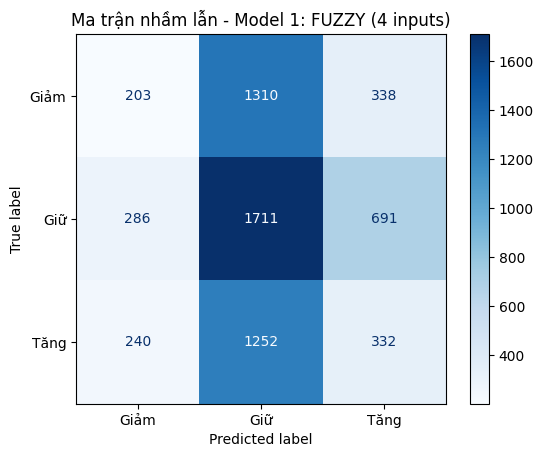


--- Model 2: HYBRID RF (6 inputs + Fuzzy) ---
              precision    recall  f1-score   support

     Giảm(0)       0.29      0.31      0.30      1851
      Giữ(1)       0.47      0.43      0.45      2688
     Tăng(2)       0.32      0.35      0.33      1824

    accuracy                           0.37      6363
   macro avg       0.36      0.36      0.36      6363
weighted avg       0.38      0.37      0.37      6363



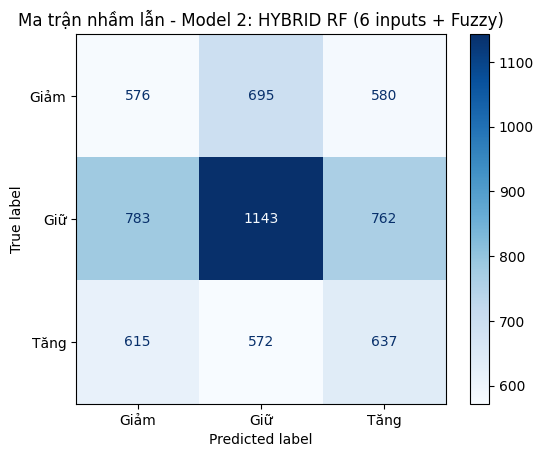


TRỰC QUAN HÓA ĐỘ CHÍNH XÁC (ROLLING ACCURACY)


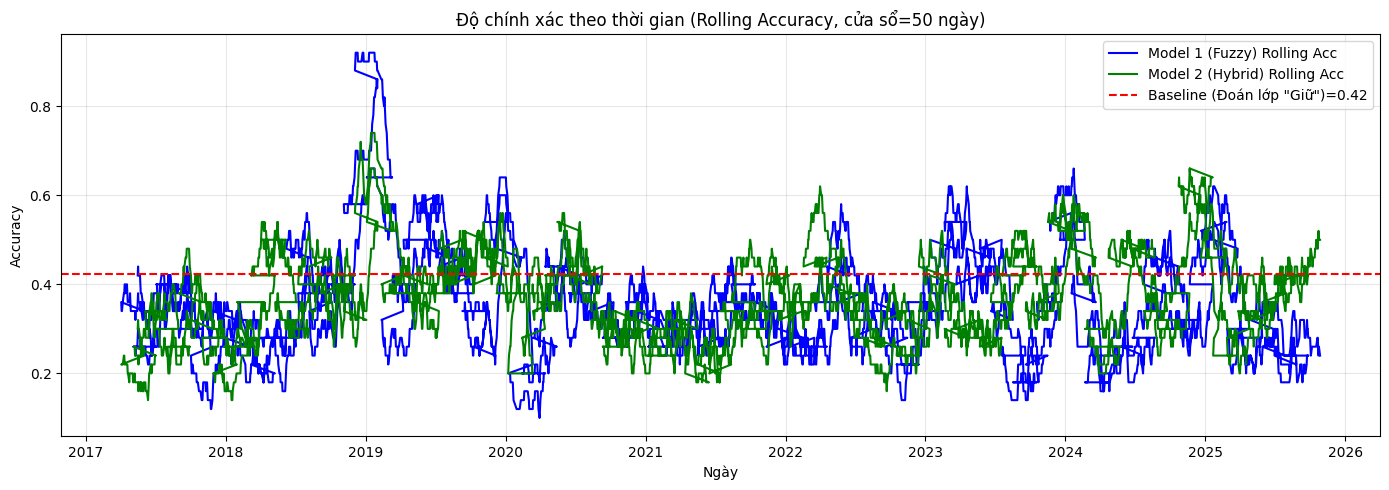


✅ HOÀN TẤT ĐÁNH GIÁ MÔ HÌNH!


In [29]:
# 5. ĐÁNH GIÁ MÔ HÌNH
print("\n" + "="*70)
print("KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH")
print("="*70)

acc_f = accuracy_score(results['fuzzy']['true'], results['fuzzy']['pred'])
acc_h = accuracy_score(results['hybrid']['true'], results['hybrid']['pred'])

print(f"• Fuzzy  Accuracy : {acc_f:.1%}")
print(f"• Hybrid Accuracy : {acc_h:.1%} ({(acc_h-acc_f)/acc_f:+.1%})")

# --- 5.1 Báo cáo chi tiết & Ma trận nhầm lẫn ---
def evaluate(name, y_true, y_pred):
    print(f"\n--- {name} ---")
    print(classification_report(y_true, y_pred, target_names=['Giảm(0)','Giữ(1)','Tăng(2)'], zero_division=0))
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
    disp = ConfusionMatrixDisplay(cm, display_labels=['Giảm','Giữ','Tăng'])
    disp.plot(cmap='Blues'); plt.title(f"Ma trận nhầm lẫn - {name}"); plt.show()

evaluate("Model 1: FUZZY (4 inputs)", results['fuzzy']['true'], results['fuzzy']['pred'])
evaluate("Model 2: HYBRID RF (6 inputs + Fuzzy)", results['hybrid']['true'], results['hybrid']['pred'])

# --- 5.2 Biểu đồ Rolling Accuracy ---
print("\n" + "="*70)
print("TRỰC QUAN HÓA ĐỘ CHÍNH XÁC (ROLLING ACCURACY)")
print("="*70)

window = 50
roll1 = pd.Series((results['fuzzy']['true'] == results['fuzzy']['pred']).astype(int)).rolling(window).mean()
roll2 = pd.Series((results['hybrid']['true'] == results['hybrid']['pred']).astype(int)).rolling(window).mean()

# Tính baseline (đoán lớp phổ biến nhất)
baseline = pd.Series(results['hybrid']['true']).value_counts(normalize=True).max()

plt.figure(figsize=(14,5))
plt.plot(pd.to_datetime(results['fuzzy']['date']), roll1, label='Model 1 (Fuzzy) Rolling Acc', color='blue')
plt.plot(pd.to_datetime(results['hybrid']['date']), roll2, label='Model 2 (Hybrid) Rolling Acc', color='green')
plt.axhline(baseline, color='red', linestyle='--', label=f'Baseline (Đoán lớp "Giữ")={baseline:.2f}')
plt.title(f'Độ chính xác theo thời gian (Rolling Accuracy, cửa sổ={window} ngày)'); plt.xlabel('Ngày'); plt.ylabel('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n{'='*70}")
print("✅ HOÀN TẤT ĐÁNH GIÁ MÔ HÌNH!")
print("="*70)


TRỰC QUAN HÓA GIÁ THỰC TẾ VÀ VÙNG DỰ ĐOÁN


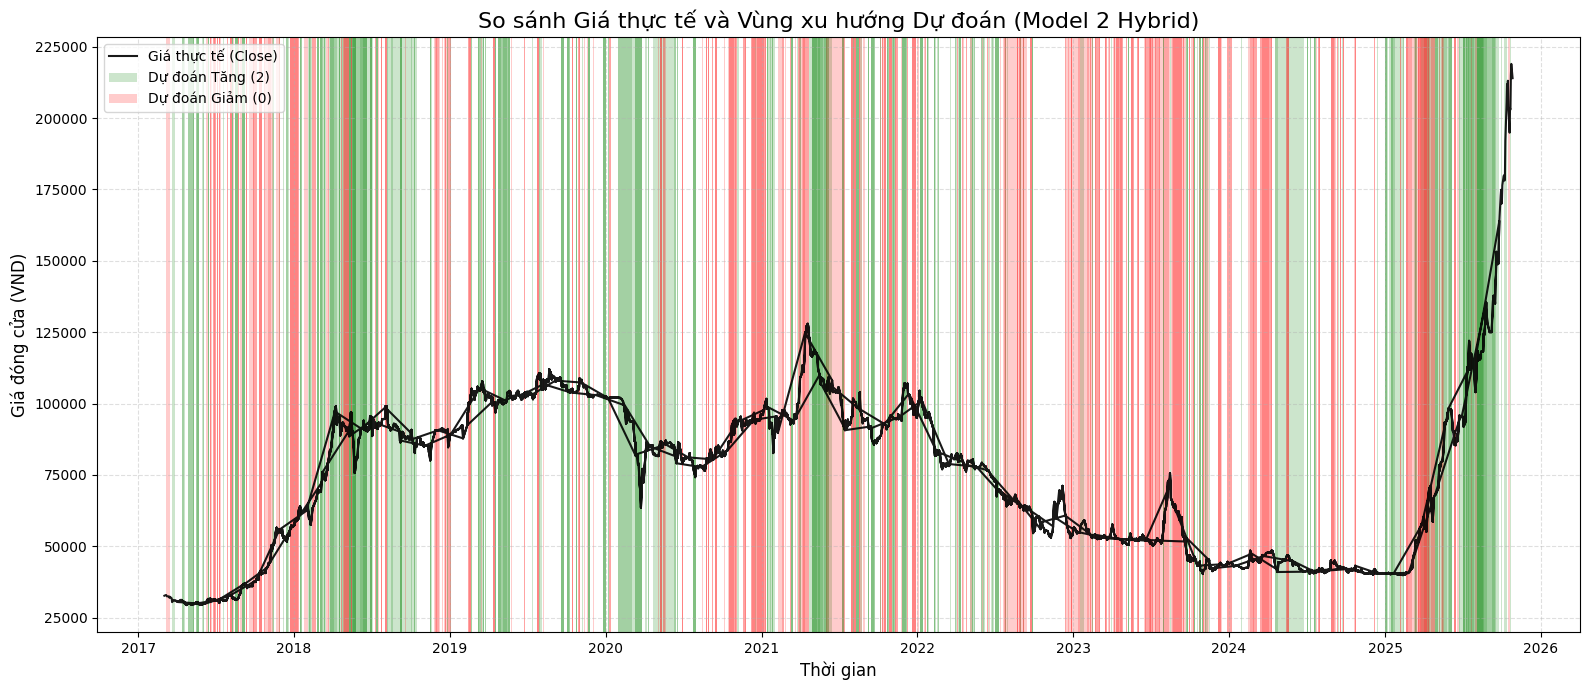

In [37]:
# --- 5.4 Biểu đồ Giá thực tế vs VÙNG TÍN HIỆU DỰ ĐOÁN ---
print("\n" + "="*70)
print("TRỰC QUAN HÓA GIÁ THỰC TẾ VÀ VÙNG DỰ ĐOÁN")
print("="*70)

# Lấy dữ liệu đã lưu từ WFA
dates_plot = pd.to_datetime(results['hybrid']['date'])
close_prices = results['hybrid']['prices']
pred_hybrid = results['hybrid']['pred']

# Tạo biểu đồ
fig, ax = plt.subplots(figsize=(16, 7))

# 1. Vẽ đường giá thực tế (màu đen)
ax.plot(dates_plot, close_prices, label='Giá thực tế (Close)', color='black', linewidth=1.5, alpha=0.9)

# 2. Lấy giới hạn trục Y để tô màu toàn bộ
y_min, y_max = ax.get_ylim()

# 3. Tô màu nền cho vùng dự đoán "Tăng" (2)
ax.fill_between(
    dates_plot,
    y_min,
    y_max,
    where=(pred_hybrid == 2),
    facecolor='green',
    alpha=0.2,
    label='Dự đoán Tăng (2)'
)

# 4. Tô màu nền cho vùng dự đoán "Giảm" (0)
ax.fill_between(
    dates_plot,
    y_min,
    y_max,
    where=(pred_hybrid == 0),
    facecolor='red',
    alpha=0.2,
    label='Dự đoán Giảm (0)'
)

# Cài đặt biểu đồ
ax.set_title("So sánh Giá thực tế và Vùng xu hướng Dự đoán (Model 2 Hybrid)", fontsize=16)
ax.set_xlabel("Thời gian", fontsize=12)
ax.set_ylabel("Giá đóng cửa (VND)", fontsize=12)
ax.legend(loc='upper left')
ax.grid(True, linestyle='--', alpha=0.4)
ax.set_ylim(y_min, y_max) # Đặt lại giới hạn Y
plt.tight_layout()
plt.show()


TRỰC QUAN HÓA GIÁ THỰC TẾ VÀ VÙNG DỰ ĐOÁN (MODEL 1 FUZZY)


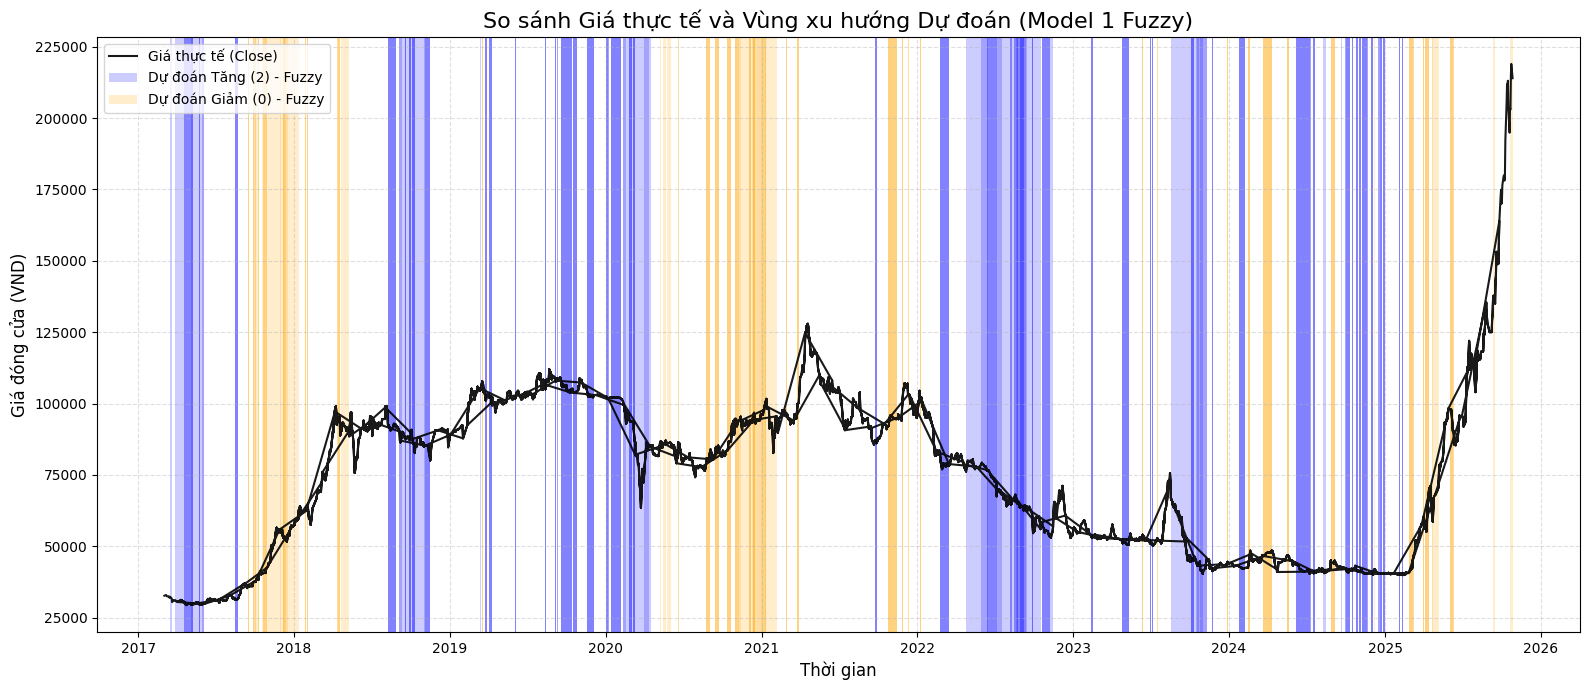

In [38]:
# --- 5.5 Biểu đồ Giá thực tế vs VÙNG TÍN HIỆU (Model 1 Fuzzy) ---
print("\n" + "="*70)
print("TRỰC QUAN HÓA GIÁ THỰC TẾ VÀ VÙNG DỰ ĐOÁN (MODEL 1 FUZZY)")
print("="*70)

# Lấy dữ liệu đã lưu từ WFA
dates_plot_f = pd.to_datetime(results['fuzzy']['date'])
close_prices_f = results['fuzzy']['prices']
pred_fuzzy = results['fuzzy']['pred']

# Tạo biểu đồ
fig, ax = plt.subplots(figsize=(16, 7))

# 1. Vẽ đường giá thực tế (màu đen)
ax.plot(dates_plot_f, close_prices_f, label='Giá thực tế (Close)', color='black', linewidth=1.5, alpha=0.9)

# 2. Lấy giới hạn trục Y
y_min, y_max = ax.get_ylim()

# 3. Tô màu nền cho vùng dự đoán "Tăng" (2)
ax.fill_between(
    dates_plot_f,
    y_min,
    y_max,
    where=(pred_fuzzy == 2),
    facecolor='blue',
    alpha=0.2,
    label='Dự đoán Tăng (2) - Fuzzy'
)

# 4. Tô màu nền cho vùng dự đoán "Giảm" (0)
ax.fill_between(
    dates_plot_f,
    y_min,
    y_max,
    where=(pred_fuzzy == 0),
    facecolor='orange',
    alpha=0.2,
    label='Dự đoán Giảm (0) - Fuzzy'
)

# Cài đặt biểu đồ
ax.set_title("So sánh Giá thực tế và Vùng xu hướng Dự đoán (Model 1 Fuzzy)", fontsize=16)
ax.set_xlabel("Thời gian", fontsize=12)
ax.set_ylabel("Giá đóng cửa (VND)", fontsize=12)
ax.legend(loc='upper left')
ax.grid(True, linestyle='--', alpha=0.4)
ax.set_ylim(y_min, y_max)
plt.tight_layout()
plt.show()